# Train Caption-ja letter classifier

Goal: **Classify letters into digits, :, /, ~ and others**

Let relevant letters = `{0-9, :, /, ~}`

Steps


1. Remove background columns from all input data

2. Get the maximum size of relevant letters -> `(nr, nc)`

3. filter out the data with size larger than `(nr+4, nc+4)`

4. Pad all remaing data to the size `(nr+4, nc+4)`

5. Train classification model on the created data
  
  A. One-step classifier
  
  B. Two-step classifer
  
    - Binary classification between relevant vs not
  
    - Multiclass classification among relevant letters

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.


In [2]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [3]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [4]:
X = np.load(os.path.join(datadir, 'X-ja.npy'))
Y = np.load(os.path.join(datadir, 'Y-ja.npy'))

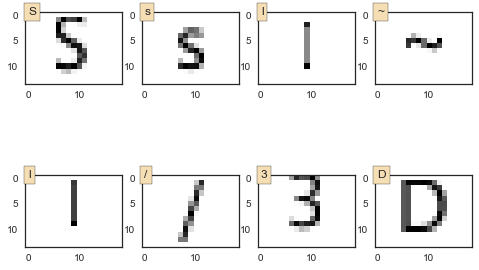

In [5]:
# convenient functions
def random_plot(X, Y, predicted=None):
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.1)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))



## Step 1 Remove background from all input data

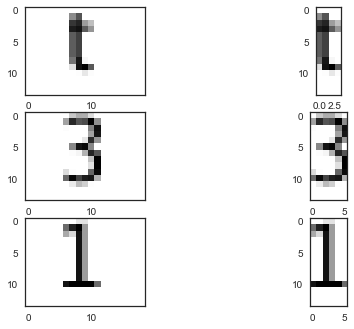

In [6]:
def remove_background(x, bg = 1.0, rows=False, cols=True):
    """
    from a image array of size (nrow, ncol),
    remove all rows and cols where values are all bg
    """
    not_bg = (x != bg)
    non_bg_rows = np.any(not_bg, axis=1)
    non_bg_cols = np.any(not_bg, axis=0)
    
    if rows:
        tmp = non_bg_rows.nonzero()[0]
        if len(tmp) == 0: return None
        i1 = tmp[0]
        i2 = tmp[-1] + 1
    else:
        i1 = 0
        i2 = x.shape[0]
    
    if cols:
        tmp = non_bg_cols.nonzero()[0]
        if len(tmp) == 0: return None
        j1 = tmp[0]
        j2 = tmp[-1] + 1
    else:
        j1 = 0
        j2 = x.shape[1]
        
    return x[i1:i2, j1:j2]

X_nobg = [remove_background(x, rows=False) for x in X]
compare_plot(X, X_nobg)

## Step 2 Get the maximum size of relevant letters -> (nr, nc)

In [7]:
max_rows = 0
max_cols = 0

relevant_letters = [s for s in '0123456789/:?']
for i in range(len(Y)):
    if Y[i] in relevant_letters:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

14 7


## Step 3 filter out the data with size larger than (nr+4, nc+4)

target shape = (18, 11)
total: 109, included: 105, out: 4
non-included samples


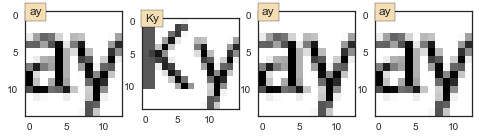

included samples


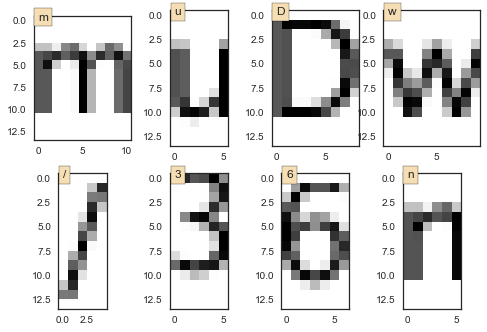

In [8]:
target_shape = (max_rows+4, max_cols+4)
print("target shape =", target_shape)
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)


## Step 4 Pad all remaing data to the size (nr+4, nc+4)

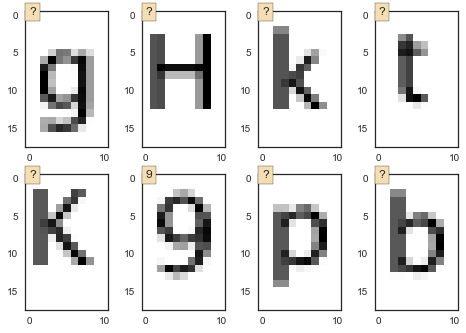

?    71
0     3
1     3
9     3
3     3
6     3
5     3
/     3
4     3
2     3
7     3
:     2
8     2
dtype: int64

In [9]:
X_in = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X_in]
X_in = [np.expand_dims(x, axis=0) for x in X_in]
X_in = np.vstack(X_in)

Y_in_true = np.array(Y_in)
Y_in = [y if y in relevant_letters else '?' for y in Y_in]
Y_in = np.array(Y_in)

random_plot(X_in, Y_in)
pd.Series(Y_in).value_counts()

## Step 5 Train classification model

In [10]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in, Y_in, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in, Y_in, 5000, seed = 7)

accuracy on original set =  0.866666666667
accuracy =  0.866666666667


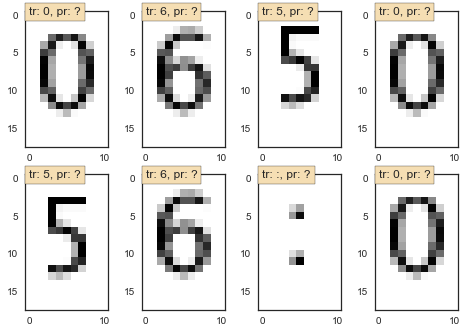

col_0  /  1  2  3  4  7  9   ?  All
row_0                              
/      3  0  0  0  0  0  0   0    3
0      0  0  0  0  0  0  0   3    3
1      0  3  0  0  0  0  0   0    3
2      0  0  3  0  0  0  0   0    3
3      0  0  0  2  0  0  0   1    3
4      0  0  0  0  3  0  0   0    3
5      0  0  0  0  0  0  0   3    3
6      0  0  0  0  0  0  0   3    3
7      0  0  0  0  0  3  0   0    3
8      0  0  0  0  0  0  0   2    2
9      0  0  0  0  0  0  3   0    3
:      0  0  0  0  0  0  0   2    2
?      0  0  0  0  0  0  0  71   71
All    3  3  3  2  3  3  3  85  105
accuracy =  0.767562706106


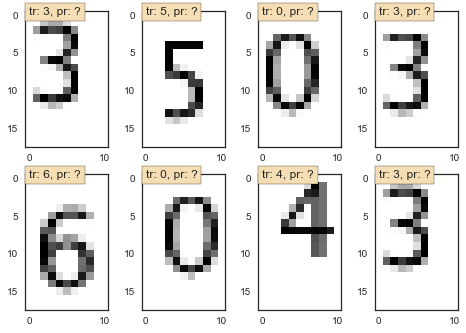

col_0    /   1    2   3    4   5    7    9     ?    All
row_0                                                  
/      162   0    0   0    0   0    0    0   124    286
0        0   0    0   0    0   0    0    0   286    286
1        0  79    0   0    0   0    0    0   206    285
2        0   0  204   0    0   0   20    0    62    286
3        0   0    0  30    0   0    0    0   256    286
4        0   0    0   0  167   0    0    0   118    285
5        0   0    0   0    0  26    0    0   261    287
6        0   0    0   0    0   0    0    0   285    285
7        0   0   11   0    0   0  182    0    92    285
8        0   0    0   0    0   0    0    0   191    191
9        0   0    0   0    0   0    0  125   161    286
:        0   0    0   0    0   0    0    0   191    191
?        0   0   47   0    0   6    7    2  6706   6768
All    162  79  262  30  167  32  209  127  8939  10007


In [11]:
# benchmark fit with support vector machine

# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}

    
pipe_svm = Pipeline([
    ('flatten', Flatten()), ('SVM', SVC())
])    
pipe_svm.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_svm.score(X_in, Y_in))
diagnosis(pipe_svm, X_in, Y_in)
diagnosis(pipe_svm, X_test, Y_test)

In [12]:
pipe_svm.classes_

array(['/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?'], 
      dtype='<U1')

SVM is not so bad! Just a naive fit achieves 80% accuracy!

### Consider Dimensionality reduction with PCA

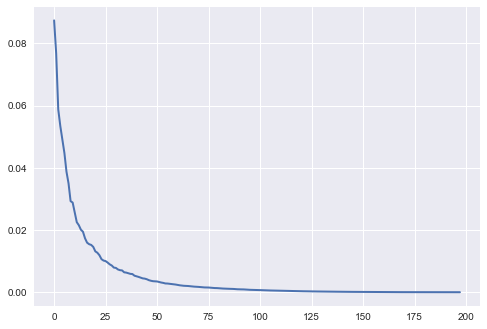

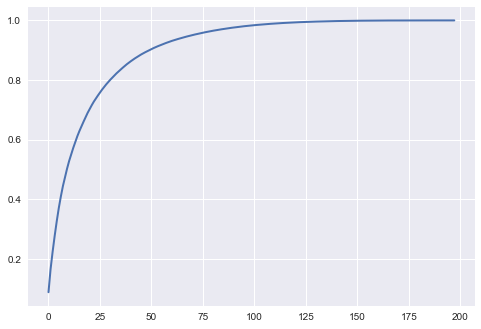

1 0.0873478478535
2 0.164094278597
3 0.222860938465
4 0.276288810822
5 0.32532734534
6 0.370036580136
7 0.408765440435
8 0.443739488477
9 0.472998344627
10 0.501814843646
11 0.527526446069
12 0.550031652677
13 0.571561499363
14 0.591654020867
15 0.611090935339
16 0.628419585221
17 0.644349214979
18 0.65977840439
19 0.67497817287
20 0.689540703329
21 0.702672307741
22 0.71535333015
23 0.727230164205
24 0.737847444836
25 0.748011475916
26 0.758009208476
27 0.767519949872
28 0.776476022223
29 0.785048190327
30 0.792957596796
31 0.80076366138
32 0.808068493346
33 0.81514542538
34 0.82214680808
35 0.828542808381
36 0.834844799683
37 0.84094831309
38 0.846848100211
39 0.852684283599
40 0.857995213555
41 0.863124486129
42 0.868042505397
43 0.8727424241
44 0.877189948342
45 0.881553882807
46 0.885722448343
47 0.889591468401
48 0.893269823545
49 0.896811625452
50 0.900316223906
51 0.903765454443
52 0.907036258903
53 0.910147049841
54 0.913137184802
55 0.915950469136
56 0.918741266345
57 0.92145

In [13]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])

Maybe 100?

### Fit MLP

In [ ]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X_in, Y_in))
diagnosis(pipe_mlp, X_test, Y_test)

MLP is just amazing... We already have 99% accuracy...

#### Grid search for finding good configuration

In [ ]:
pipe_grid = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
]) 
ncomp_options = [75, 100, 125]
alpha_options = [0.0001, 0.001, 0.01, 0.1]
layer_options = [(100,), (100,100), (100,100,100)]
param_grid = dict(
    PCA__n_components=ncomp_options,
    MLP__alpha=alpha_options,
    MLP__hidden_layer_sizes=layer_options
)

grid_savename = os.path.join(arcdir, 'caption-ja_pca-mlp-grid_all.pkl')
if True:  # change to True to do grid search again
    grid = GridSearchCV(pipe_grid, param_grid, cv=5, n_jobs=2, verbose=5)
    grid.fit(X_train, Y_train)
    
    joblib.dump(grid, grid_savename)
else:
    grid = joblib.load(grid_savename)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
odr = np.argsort(grid.cv_results_['mean_test_score'])
for i in reversed(odr):
    print("%0.4f (+/-%0.04f) for %r" % 
        (grid.cv_results_['mean_test_score'][i], 
         grid.cv_results_['std_test_score'][i] * 2, 
         grid.cv_results_['params'][i]))
print(grid.best_params_)

In [ ]:
print('accuracy on original set = ', grid.score(X_in, Y_in))

diagnosis(grid, X_in, Y_in)
diagnosis(grid, X_test, Y_test)

In [ ]:
savename = os.path.join(modeldir, 'caption_pca-mlp-gridbest.pkl')

pipe = Pipeline([
    ('PCA', grid.best_estimator_.named_steps['PCA']),
    ('MLP', grid.best_estimator_.named_steps['MLP'])
])
joblib.dump(pipe, savename)

#### Exhaustive training until perfect accuracy

In [ ]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=125)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = grid.best_estimator_.classes_

train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in, Y_in, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in, Y_in)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

In [ ]:
diagnosis(pipe_pred, X_in, Y_in)
diagnosis(pipe_pred, X_test, Y_test)

In [ ]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [ ]:
# save PCA-MLP part
savename = os.path.join(modeldir, 'caption-ja_pca-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

This model looks reasonable!  This would be our first choice.

### Two step classification

#### Classify relevant vs not

In [ ]:
Y_in1 = (Y_in != '?') 

# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in, Y_in1, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in, Y_in1, 5000, seed = 7)

**Logistic regression**

In [ ]:
pipe = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('Logit', LogisticRegression(penalty='l1'))
])
pipe.fit(X_train, Y_train)

diagnosis(pipe, X_test, Y_test)
diagnosis(pipe, X_in, Y_in1)

**MLP**

In [ ]:
pipe = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.001))
])
pipe.fit(X_train, Y_train)



diagnosis(pipe, X_test, Y_test)
diagnosis(pipe, X_in, Y_in1)

**Exhaustive traiging**

In [ ]:
classes = pipe.named_steps['MLP'].classes_

In [ ]:
np.random.seed(87)


# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=125)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])


train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in, Y_in1, 500)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in, Y_in1)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

In [ ]:
diagnosis(pipe_pred, X_in, Y_in1)
diagnosis(pipe_pred, X_test, Y_test)

In [ ]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [ ]:
savename = os.path.join(modeldir, 'caption-ja_pca-mlp-step1-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

#### Classification among relevant letters

In [ ]:
X_in2 = X_in[Y_in != '?']
Y_in2 = Y_in[Y_in != '?']

pd.Series(Y_in2).value_counts()

# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X_in2, Y_in2, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X_in2, Y_in2, 5000, seed = 7)

In [ ]:
pipe_pca = Pipeline([('flatten', Flatten()), ('PCA', PCA())]) 
pipe_pca.fit(X_train)

sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])

100 or 80?

In [ ]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), ('PCA', PCA(n_components=80)), ('MLP', MLPClassifier())
]) 
pipe_mlp.fit(X_train, Y_train)
diagnosis(pipe_mlp, X_test, Y_test)
diagnosis(pipe_mlp, X_in2, Y_in2)

classes = pipe_mlp.named_steps['MLP'].classes_
classes

In [ ]:
np.random.seed(87)


# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=80)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])


train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X_in2, Y_in2, 500)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X_in2, Y_in2)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

In [ ]:
diagnosis(pipe_pred, X_in2, Y_in2)
diagnosis(pipe_pred, X_test, Y_test)

In [ ]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [ ]:
savename = os.path.join(modeldir, 'caption-ja_pca-mlp-step2-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

It seems that the second step (classification among relevant letters) is much easier than that first step (classification between relevant vs non-relevant letters).  I guess the main reason is similarity between `S` and `5`, `Z` and `2`, etc.  
Also, since we will have a lot more unseen letters in the practice, some care will be needed.
One idea is that, for example, if a letter is between two or three consecutive relevant letter, we assume the letter is also relevant.  With this type of aid to create consecutive relevant letters, the second step classification will not fail almost surely. 

Finally, save the input shape as the reference for later application.

In [ ]:
with open(os.path.join(modeldir, 'caption-ja-config.json'), 'w') as file:
    json.dump(dict(input_shape=X_in.shape[1:]), file)